In [1]:
from transformer_BigBirdA2C import *
from dataset import make_data_generator
import json
from tqdm import tqdm_notebook as tqdm
#from torchsummary import summary

In [2]:
folder = 'data/BBC/'
data_name = folder+'data.json'
# validation_name = folder+'valid_seq.json'
# testdata_name = folder+'testdata_seq.json'
vocab_name = folder+'vocab.json'

In [3]:
num_epochs = 1000
save_rate = 1 #how many epochs per modelsave
#continue_from = "trained/Model1" # if none, put None
continue_from = None
epsilon = 1e-8
validation_size = 10000
device = torch.device('cuda')
!mkdir -p trained

In [4]:
vocab = json.load(open(vocab_name, 'r'))
VOC_SIZE = len(vocab)
INPUT_MAX = 100
SUMM_MAX = 20
UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

In [5]:
batch_size = 16

training_set, training_generator = make_data_generator(\
data_name, INPUT_MAX, SUMM_MAX, vocab[PAD], batch_size, cutoff=None, shuffle=True, num_workers=4)

# validation_set, validation_generator = make_data_generator(\
# validation_name, INPUT_MAX, OUTPUT_MAX, vocab[PAD], batch_size, cutoff=validation_size, shuffle=False, num_workers=4)

def data_gen_train():
    for src, label, tgt in training_generator:
        src = src.to(device)
        label = (label).long().to(device)
        tgt = tgt.to(device)
        b = Batch(src, tgt, vocab[PAD])
        b.label = label
        yield b

loading json
load json done.


In [6]:
import math
total_train = int(math.ceil(training_set.size / batch_size))
# total_valid = int(math.ceil(validation_set.size / batch_size))
# print(total_train, total_valid)

In [7]:
def make_translator(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, emb_share=False):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    src_emb = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
    tgt_emb = src_emb if emb_share else nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))
    
    model = Translator(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        src_emb,
        tgt_emb,
        Generator(d_model, tgt_vocab))
    
    return model

In [8]:
def make_classifier(src_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    bert = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        vocab[PAD]
    )
    
    model = Classifier(
        bert
        # criterion = CE
    )

    return model

In [9]:
def make_discriminator(src_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    bert = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        vocab[PAD]
    )
    
    model = Discriminator(
        bert
    )
    
    return model

In [10]:
def init_param(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def make_big_bird(vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, emb_share=False, bert_share=False):
    "Helper: Construct a model from hyperparameters."
    
    vocab_sz = len(vocab)
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    src_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    if emb_share:        
        tgt_emb = src_emb
        bert_class_emb = src_emb
        bert_discr_emb = src_emb
    else:
        tgt_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_class_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_discr_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    
    
    bert_class = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        bert_class_emb,
        vocab[PAD]
    )
    
    if bert_share:
        bert_discr = bert_class
    else:
        bert_discr = BERT(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            bert_discr_emb,
            vocab[PAD]
        )
    
    translator = Translator(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        src_emb,
        tgt_emb,
        Generator(d_model, vocab_sz),
        CriticNet(d_model)
        )
    
    classifier = Classifier(
        bert_class
        # criterion = BCE
    )
        
    discriminator = Discriminator(
        bert_discr
    )
        
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for m in [translator, classifier, discriminator]:
        init_param(m)
            
    # creation of big bird
    model = BigBird(
        translator, discriminator, classifier, 
        vocab, gamma=0.99, clip_value=0.1, #for WGAN, if WGAN-GP is used this is useless 
        lr_G = 0.0,
        lr_D = 0.0,
        lr_C = 2e-6,
        LAMBDA = 10, # Gradient penalty lambda hyperparameter
        RL_scale = 1,
        device = device
    )

    return model


In [11]:
model = make_big_bird(vocab, N=4, d_model=256, d_ff=512, h=8, dropout=0.1, emb_share=True, bert_share=True)
#model.load("Nest/NewbornBirdA2C")

In [12]:
vocab_inv = {a:b for b, a in vocab.items()}
def convert_ids_to_tokens(ids):
    return [vocab_inv[i] for i in ids]

In [13]:
start = 1 if continue_from == None else (int(continue_from.split("Model")[-1])+1)
history = []


from tensorboardX import SummaryWriter
writer = SummaryWriter('mygraph')

for epoch in range(start, num_epochs+1):
    print("Epoch", epoch)
    
    # training
    stats = Stats()
    model.train()
    trange = tqdm(enumerate(data_gen_train()), total=total_train)
    for i, batch in trange:
        loss, score  = model.run_iter(batch.src, batch.src_mask, SUMM_MAX, batch.trg, batch.label, writer, D_iters=1, verbose = 0)
        trange.set_postfix(
            **{'RL_loss': '{:.3f}'.format(loss[0])},
            **{'G_loss': '{:.3f}'.format(loss[1])},
            **{'D_loss': '{:.3f}'.format(loss[2])},
            **{'real_score': '{:.3f}'.format(score[0])},
            **{'fake_score': '{:.3f}'.format(score[1])},
            **{'acc': '{:.3f}'.format(score[2])},
            **{'reward':'{:.3f}'.format(score[3])}
        )
        stats.update(score[3], 1, log=0)
        
    t_h = stats.history
    history.append(t_h)
    writer.add_scalar('reward', np.mean(t_h), epoch)
    print("[info] epoch train reward:", np.mean(t_h))
writer.close()  
#     try:
#         torch.save({'model':model.state_dict(), 'training_history':t_h, 'validation_loss':np.mean(v_h)}, 
#                    "trained/Model"+str(epoch))
#     except:
#         continue

Epoch 1



[info] epoch train reward: -1.841782294852393
Epoch 2



[info] epoch train reward: -1.7611868253776006
Epoch 3



[info] epoch train reward: -1.7335351066929954
Epoch 4



[info] epoch train reward: -1.7220943484987532
Epoch 5



[info] epoch train reward: -1.7173928345952716
Epoch 6



[info] epoch train reward: -1.7037312848227364
Epoch 7



[info] epoch train reward: -1.7104440476213183
Epoch 8


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.7010101786681584
Epoch 9



[info] epoch train reward: -1.678793626172202
Epoch 10



[info] epoch train reward: -1.683279869386128
Epoch 11



[info] epoch train reward: -1.6835743010044097
Epoch 12



[info] epoch train reward: -1.6918682949883597
Epoch 13



[info] epoch train reward: -1.689210012129375
Epoch 14



[info] epoch train reward: -1.6815303572586604
Epoch 15


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6877284680094038
Epoch 16



[info] epoch train reward: -1.6707951511655534
Epoch 17



[info] epoch train reward: -1.67403650198664
Epoch 18



[info] epoch train reward: -1.66787434560912
Epoch 19



[info] epoch train reward: -1.6571273020335606
Epoch 20



[info] epoch train reward: -1.6522072408880506
Epoch 21



[info] epoch train reward: -1.6532670523439135
Epoch 22


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6602996987955911
Epoch 23



[info] epoch train reward: -1.6678507481302534
Epoch 24



[info] epoch train reward: -1.660029775755746
Epoch 25



[info] epoch train reward: -1.656170415026801
Epoch 26



[info] epoch train reward: -1.6554619950907572
Epoch 27



[info] epoch train reward: -1.6477929830551148
Epoch 28



[info] epoch train reward: -1.6577823536736624
Epoch 29


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6553236288683755
Epoch 30



[info] epoch train reward: -1.6514618158340455
Epoch 31



[info] epoch train reward: -1.6562910088471003
Epoch 32



[info] epoch train reward: -1.6560745281832558
Epoch 33



[info] epoch train reward: -1.6529193137373244
Epoch 34



[info] epoch train reward: -1.6458630119051252
Epoch 35



[info] epoch train reward: -1.642976611001151
Epoch 36


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6388142619814192
Epoch 37



[info] epoch train reward: -1.657322723524911
Epoch 38



[info] epoch train reward: -1.6511045055730003
Epoch 39



[info] epoch train reward: -1.6446661344596318
Epoch 40



[info] epoch train reward: -1.6432126828602382
Epoch 41



[info] epoch train reward: -1.6480140703065054
Epoch 42



[info] epoch train reward: -1.6423301134790693
Epoch 43


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6482308575085232
Epoch 44



[info] epoch train reward: -1.6337278621537346
Epoch 45



[info] epoch train reward: -1.6440812366349356
Epoch 46



[info] epoch train reward: -1.638881380217416
Epoch 47



[info] epoch train reward: -1.6460107743740082
Epoch 48



[info] epoch train reward: -1.640561910186495
Epoch 49



[info] epoch train reward: -1.6465488936219896
Epoch 50


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.638019677570888
Epoch 51



[info] epoch train reward: -1.6411275097302027
Epoch 52



[info] epoch train reward: -1.6309447186333792
Epoch 53



[info] epoch train reward: -1.643798305307116
Epoch 54



[info] epoch train reward: -1.64012839112963
Epoch 55



[info] epoch train reward: -1.6348545117037636
Epoch 56



[info] epoch train reward: -1.6391675191266195
Epoch 57



[info] epoch train reward: -1.6340533001082285
Epoch 58


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6339773901871273
Epoch 59



[info] epoch train reward: -1.6284839493887766
Epoch 60



[info] epoch train reward: -1.6276083503450667
Epoch 61



[info] epoch train reward: -1.6255848169326783
Epoch 62



[info] epoch train reward: -1.634344050713948
Epoch 63



[info] epoch train reward: -1.6342063895293644
Epoch 64



[info] epoch train reward: -1.6299619265965053
Epoch 65


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6308756836823055
Epoch 66



[info] epoch train reward: -1.6338449197156089
Epoch 67



[info] epoch train reward: -1.6326584228447505
Epoch 68



[info] epoch train reward: -1.6291308803217752
Epoch 69



[info] epoch train reward: -1.636717348439353
Epoch 70



[info] epoch train reward: -1.6372392177581787
Epoch 71



[info] epoch train reward: -1.6407364189624787
Epoch 72


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6228373953274318
Epoch 73



[info] epoch train reward: -1.635917087963649
Epoch 74



[info] epoch train reward: -1.6230343205588205
Epoch 75



[info] epoch train reward: -1.6289810104029518
Epoch 76



[info] epoch train reward: -1.6349617677075523
Epoch 77



[info] epoch train reward: -1.6411471792629786
Epoch 78



[info] epoch train reward: -1.6340294361114502
Epoch 79


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6409158212797983
Epoch 80



[info] epoch train reward: -1.6286239879471915
Epoch 81



[info] epoch train reward: -1.6322818909372603
Epoch 82



[info] epoch train reward: -1.628996490580695
Epoch 83



[info] epoch train reward: -1.6288816818169185
Epoch 84



[info] epoch train reward: -1.6313328419412885
Epoch 85



[info] epoch train reward: -1.629107607262475
Epoch 86


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.623291709593364
Epoch 87



[info] epoch train reward: -1.6336516014167242
Epoch 88



[info] epoch train reward: -1.631823572090694
Epoch 89



[info] epoch train reward: -1.6224754750728607
Epoch 90



[info] epoch train reward: -1.6239921637943813
Epoch 91



[info] epoch train reward: -1.6302751515592848
Epoch 92



[info] epoch train reward: -1.6413778339113507
Epoch 93


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6297178992203303
Epoch 94



[info] epoch train reward: -1.6309559498514448
Epoch 95



[info] epoch train reward: -1.6264934590884617
Epoch 96



[info] epoch train reward: -1.637516267810549
Epoch 97



[info] epoch train reward: -1.6197030646460397
Epoch 98



[info] epoch train reward: -1.6228535916124072
Epoch 99



[info] epoch train reward: -1.6262211220605032
Epoch 100


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6323855246816363
Epoch 101



[info] epoch train reward: -1.6203978163855417
Epoch 102



[info] epoch train reward: -1.6190722806113107
Epoch 103



[info] epoch train reward: -1.6229964801243373
Epoch 104



[info] epoch train reward: -1.6215977336679186
Epoch 105



[info] epoch train reward: -1.6201933911868505
Epoch 106



[info] epoch train reward: -1.6291104120867592
Epoch 107



[info] epoch train reward: -1.6193038208144053
Epoch 108


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6276261559554508
Epoch 109



[info] epoch train reward: -1.6193971003804888
Epoch 110



[info] epoch train reward: -1.6308204523154668
Epoch 111



[info] epoch train reward: -1.6266639939376286
Epoch 112



[info] epoch train reward: -1.6239928211484636
Epoch 113



[info] epoch train reward: -1.6198984835829053
Epoch 114



[info] epoch train reward: -1.6205903027738844
Epoch 115


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6256244097437178
Epoch 116



[info] epoch train reward: -1.6250829330512455
Epoch 117



[info] epoch train reward: -1.6245571996484485
Epoch 118



[info] epoch train reward: -1.6192475753171103
Epoch 119



[info] epoch train reward: -1.6310732339109693
Epoch 120



[info] epoch train reward: -1.626885052238192
Epoch 121



[info] epoch train reward: -1.6230410950524465
Epoch 122


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6243249297142028
Epoch 123



[info] epoch train reward: -1.6230669498443604
Epoch 124



[info] epoch train reward: -1.6235481364386422
Epoch 125



[info] epoch train reward: -1.6180610733372824
Epoch 126



[info] epoch train reward: -1.6145543021815163
Epoch 127



[info] epoch train reward: -1.6266799594674792
Epoch 128



[info] epoch train reward: -1.6214536087853568
Epoch 129


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6284796025071826
Epoch 130



[info] epoch train reward: -1.6232988204274859
Epoch 131



[info] epoch train reward: -1.6273877731391362
Epoch 132



[info] epoch train reward: -1.624106855051858
Epoch 133



[info] epoch train reward: -1.6245351748807089
Epoch 134



[info] epoch train reward: -1.6218519755772183
Epoch 135



[info] epoch train reward: -1.6242228158882686
Epoch 136


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6206454677241189
Epoch 137



[info] epoch train reward: -1.6225020400115422
Epoch 138



[info] epoch train reward: -1.6250443807670047
Epoch 139



[info] epoch train reward: -1.6246287294796535
Epoch 140



[info] epoch train reward: -1.6228272480624062
Epoch 141



[info] epoch train reward: -1.6174973266465322
Epoch 142



[info] epoch train reward: -1.6244996837207248
Epoch 143


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.621285741669791
Epoch 144



[info] epoch train reward: -1.6226042211055756
Epoch 145



[info] epoch train reward: -1.6206864382539476
Epoch 146



[info] epoch train reward: -1.624776073864528
Epoch 147



[info] epoch train reward: -1.6217280541147505
Epoch 148



[info] epoch train reward: -1.6175445573670524
Epoch 149



[info] epoch train reward: -1.6137055592877525
Epoch 150


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6193654605320522
Epoch 151



[info] epoch train reward: -1.627474283320563
Epoch 152



[info] epoch train reward: -1.619846509184156
Epoch 153



[info] epoch train reward: -1.6246083506516047
Epoch 154



[info] epoch train reward: -1.6249619117804937
Epoch 155



[info] epoch train reward: -1.6214253646986825
Epoch 156



[info] epoch train reward: -1.6225331476756504
Epoch 157



[info] epoch train reward: -1.622583818435669
Epoch 158


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6203258412224906
Epoch 159



[info] epoch train reward: -1.62439255799566
Epoch 160



[info] epoch train reward: -1.6215593601976122
Epoch 161



[info] epoch train reward: -1.6188778332301548
Epoch 162



[info] epoch train reward: -1.6181489152567727
Epoch 163



[info] epoch train reward: -1.6192066056387766
Epoch 164



[info] epoch train reward: -1.6221909863608224
Epoch 165


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6209235991750444
Epoch 166



[info] epoch train reward: -1.6184859020369393
Epoch 167



[info] epoch train reward: -1.616011117185865
Epoch 168



[info] epoch train reward: -1.62362984589168
Epoch 169



[info] epoch train reward: -1.620330320937293
Epoch 170



[info] epoch train reward: -1.6238668041569846
Epoch 171



[info] epoch train reward: -1.629257526568004
Epoch 172


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6265066053186144
Epoch 173



[info] epoch train reward: -1.6257642558642795
Epoch 174



[info] epoch train reward: -1.6253381422587803
Epoch 175



[info] epoch train reward: -1.6192201810223716
Epoch 176



[info] epoch train reward: -1.6222384767872946
Epoch 177



[info] epoch train reward: -1.61483696103096
Epoch 178



[info] epoch train reward: -1.6217073704515184
Epoch 179


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6218641238553184
Epoch 180



[info] epoch train reward: -1.620611550978252
Epoch 181



[info] epoch train reward: -1.6161018448216575
Epoch 182



[info] epoch train reward: -1.6128145924636297
Epoch 183



[info] epoch train reward: -1.626884641817638
Epoch 184



[info] epoch train reward: -1.6215373022215707
Epoch 185



[info] epoch train reward: -1.6188759795257024
Epoch 186


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6225703469344548
Epoch 187



[info] epoch train reward: -1.6184813584600175
Epoch 188



[info] epoch train reward: -1.615644976070949
Epoch 189



[info] epoch train reward: -1.6179690250328609
Epoch 190



[info] epoch train reward: -1.6176456476960863
Epoch 191



[info] epoch train reward: -1.620809518439429
Epoch 192



[info] epoch train reward: -1.621528398990631
Epoch 193


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6145504363945553
Epoch 194



[info] epoch train reward: -1.6170016135488237
Epoch 195



[info] epoch train reward: -1.6215660393238067
Epoch 196



[info] epoch train reward: -1.6154257135731833
Epoch 197



[info] epoch train reward: -1.6180646751608168
Epoch 198



[info] epoch train reward: -1.617659272466387
Epoch 199



[info] epoch train reward: -1.6215950318745205
Epoch 200


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6182037225791386
Epoch 201



[info] epoch train reward: -1.6193251371383668
Epoch 202



[info] epoch train reward: -1.6156081216675895
Epoch 203



[info] epoch train reward: -1.6171161362103053
Epoch 204



[info] epoch train reward: -1.6135934497628892
Epoch 205



[info] epoch train reward: -1.6137325244290488
Epoch 206



[info] epoch train reward: -1.6206088636602674
Epoch 207



[info] epoch train reward: -1.6222377462046487
Epoch 208


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.617999109200069
Epoch 209



[info] epoch train reward: -1.6144984143120902
Epoch 210



[info] epoch train reward: -1.6181960327284677
Epoch 211



[info] epoch train reward: -1.6189159614699227
Epoch 212



[info] epoch train reward: -1.6175893630300249
Epoch 213



[info] epoch train reward: -1.6169247448444366
Epoch 214



[info] epoch train reward: -1.6183897418635231
Epoch 215


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6162456469876425
Epoch 216



[info] epoch train reward: -1.6174826102597373
Epoch 217



[info] epoch train reward: -1.6212009131908416
Epoch 218



[info] epoch train reward: -1.6156015591961996
Epoch 219



[info] epoch train reward: -1.621408259868622
Epoch 220



[info] epoch train reward: -1.6187907866069249
Epoch 221



[info] epoch train reward: -1.6220357273306165
Epoch 222


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6174163162708282
Epoch 223



[info] epoch train reward: -1.6150619217327662
Epoch 224



[info] epoch train reward: -1.6202566615172795
Epoch 225



[info] epoch train reward: -1.6196955697877067
Epoch 226



[info] epoch train reward: -1.6238326711314066
Epoch 227



[info] epoch train reward: -1.6170336135796137
Epoch 228



[info] epoch train reward: -1.61819497857775
Epoch 229


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6227927122797285
Epoch 230



[info] epoch train reward: -1.6143373361655644
Epoch 231



[info] epoch train reward: -1.6180220203740256
Epoch 232



[info] epoch train reward: -1.6133194948945726
Epoch 233



[info] epoch train reward: -1.618729305267334
Epoch 234



[info] epoch train reward: -1.6157512153897966
Epoch 235



[info] epoch train reward: -1.617493133034025
Epoch 236


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6210802631718773
Epoch 237



[info] epoch train reward: -1.6123598822525569
Epoch 238



[info] epoch train reward: -1.6163543726716723
Epoch 239



[info] epoch train reward: -1.615407600573131
Epoch 240



[info] epoch train reward: -1.6140968816620962
Epoch 241



[info] epoch train reward: -1.6155907332897186
Epoch 242



[info] epoch train reward: -1.6132270319121225
Epoch 243


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6179990359715053
Epoch 244



[info] epoch train reward: -1.6203341833182743
Epoch 245



[info] epoch train reward: -1.6168529536042895
Epoch 246



[info] epoch train reward: -1.6170426445347923
Epoch 247



[info] epoch train reward: -1.620572280883789
Epoch 248



[info] epoch train reward: -1.6162311886038099
Epoch 249



[info] epoch train reward: -1.616421459402357
Epoch 250


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6132160765784127
Epoch 251



[info] epoch train reward: -1.6141120399747575
Epoch 252



[info] epoch train reward: -1.6166787564754486
Epoch 253



[info] epoch train reward: -1.6159393072128296
Epoch 254



[info] epoch train reward: -1.6158965340682439
Epoch 255



[info] epoch train reward: -1.6170085098062243
Epoch 256



[info] epoch train reward: -1.620007655450276
Epoch 257



[info] epoch train reward: -1.6180967322417668
Epoch 258


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6151409029960633
Epoch 259



[info] epoch train reward: -1.6168398823056902
Epoch 260



[info] epoch train reward: -1.6147711166313716
Epoch 261



[info] epoch train reward: -1.6194529661110468
Epoch 262



[info] epoch train reward: -1.61934500677245
Epoch 263



[info] epoch train reward: -1.6206406099455697
Epoch 264



[info] epoch train reward: -1.620903275694166
Epoch 265


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6175708455698832
Epoch 266



[info] epoch train reward: -1.6149415458951677
Epoch 267



[info] epoch train reward: -1.6175892208303724
Epoch 268



[info] epoch train reward: -1.619145850624357
Epoch 269



[info] epoch train reward: -1.6204024519239153
Epoch 270



[info] epoch train reward: -1.615793934038707
Epoch 271



[info] epoch train reward: -1.6173150522368296
Epoch 272


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6195473100457873
Epoch 273



[info] epoch train reward: -1.6134906760283878
Epoch 274



[info] epoch train reward: -1.6155509982790266
Epoch 275



[info] epoch train reward: -1.6154835198606763
Epoch 276



[info] epoch train reward: -1.6163601211139134
Epoch 277



[info] epoch train reward: -1.6168336272239685
Epoch 278



[info] epoch train reward: -1.6169585841042655
Epoch 279


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6177107274532319
Epoch 280



[info] epoch train reward: -1.614845450435366
Epoch 281



[info] epoch train reward: -1.6148701335702624
Epoch 282



[info] epoch train reward: -1.618950127703803
Epoch 283



[info] epoch train reward: -1.6181408132825579
Epoch 284



[info] epoch train reward: -1.6161019836153303
Epoch 285



[info] epoch train reward: -1.6142509400844574
Epoch 286


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6126131892204285
Epoch 287



[info] epoch train reward: -1.613347317491259
Epoch 288



[info] epoch train reward: -1.6122685194015502
Epoch 289



[info] epoch train reward: -1.6166409543582372
Epoch 290



[info] epoch train reward: -1.6166831297533852
Epoch 291



[info] epoch train reward: -1.6151710041931697
Epoch 292



[info] epoch train reward: -1.6155953092234476
Epoch 293


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.613081260238375
Epoch 294



[info] epoch train reward: -1.6131078285830363
Epoch 295



[info] epoch train reward: -1.6155798622540065
Epoch 296



[info] epoch train reward: -1.6122280819075447
Epoch 297



[info] epoch train reward: -1.6119944759777614
Epoch 298



[info] epoch train reward: -1.6143059866768974
Epoch 299



[info] epoch train reward: -1.6144301559243883
Epoch 300


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6193749112742288
Epoch 301



[info] epoch train reward: -1.609452302966799
Epoch 302



[info] epoch train reward: -1.613935557433537
Epoch 303



[info] epoch train reward: -1.617541264636176
Epoch 304



[info] epoch train reward: -1.6120694083826883
Epoch 305



[info] epoch train reward: -1.610592370373862
Epoch 306



[info] epoch train reward: -1.619261120898383
Epoch 307



[info] epoch train reward: -1.617457423039845
Epoch 308


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6143035607678549
Epoch 309



[info] epoch train reward: -1.611585864850453
Epoch 310



[info] epoch train reward: -1.6154506155422756
Epoch 311



[info] epoch train reward: -1.614094374009541
Epoch 312



[info] epoch train reward: -1.6134159028530122
Epoch 313



[info] epoch train reward: -1.6168404987880163
Epoch 314



[info] epoch train reward: -1.6139441422053746
Epoch 315


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6160336298601967
Epoch 316



[info] epoch train reward: -1.6131812044552394
Epoch 317



[info] epoch train reward: -1.6131036375250136
Epoch 318



[info] epoch train reward: -1.6148024337632316
Epoch 319



[info] epoch train reward: -1.6188397458621433
Epoch 320



[info] epoch train reward: -1.6121838680335454
Epoch 321



[info] epoch train reward: -1.6112544800554003
Epoch 322


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6144382229873113
Epoch 323



[info] epoch train reward: -1.6127849740641458
Epoch 324



[info] epoch train reward: -1.620202331032072
Epoch 325



[info] epoch train reward: -1.617555651494435
Epoch 326



[info] epoch train reward: -1.617638350384576
Epoch 327



[info] epoch train reward: -1.6158726138728006
Epoch 328



[info] epoch train reward: -1.6151542169707163
Epoch 329


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6134392295564923
Epoch 330



[info] epoch train reward: -1.6180392742156982
Epoch 331



[info] epoch train reward: -1.6143371301037925
Epoch 332



[info] epoch train reward: -1.6137528555733818
Epoch 333



[info] epoch train reward: -1.6153390603406088
Epoch 334



[info] epoch train reward: -1.611791650738035
Epoch 335



[info] epoch train reward: -1.6127027826649802
Epoch 336


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6109237483569554
Epoch 337



[info] epoch train reward: -1.6148851241384234
Epoch 338



[info] epoch train reward: -1.612515619822911
Epoch 339



[info] epoch train reward: -1.6152819531304496
Epoch 340



[info] epoch train reward: -1.6150976836681366
Epoch 341



[info] epoch train reward: -1.6144585805279867
Epoch 342



[info] epoch train reward: -1.6154782116413116
Epoch 343


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6173099815845489
Epoch 344



[info] epoch train reward: -1.6094769741807664
Epoch 345



[info] epoch train reward: -1.6127641328743525
Epoch 346



[info] epoch train reward: -1.6168087814535415
Epoch 347



[info] epoch train reward: -1.6135503879615238
Epoch 348



[info] epoch train reward: -1.613655927351543
Epoch 349



[info] epoch train reward: -1.6121242378439222
Epoch 350


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6133547689233507
Epoch 351



[info] epoch train reward: -1.6146749820028032
Epoch 352



[info] epoch train reward: -1.613239769424711
Epoch 353



[info] epoch train reward: -1.6142191767692566
Epoch 354



[info] epoch train reward: -1.6102623769215174
Epoch 355



[info] epoch train reward: -1.6142444159303393
Epoch 356



[info] epoch train reward: -1.617978845323835
Epoch 357



[info] epoch train reward: -1.6123466117041452
Epoch 358


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6142150793756758
Epoch 359



[info] epoch train reward: -1.6108158571379525
Epoch 360



[info] epoch train reward: -1.6142103706087385
Epoch 361



[info] epoch train reward: -1.6131978460720606
Epoch 362



[info] epoch train reward: -1.6129688390663692
Epoch 363



[info] epoch train reward: -1.6122113508837563
Epoch 364



[info] epoch train reward: -1.6143314370087214
Epoch 365


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6131924118314471
Epoch 366



[info] epoch train reward: -1.6135545194149017
Epoch 367



[info] epoch train reward: -1.6166314959526062
Epoch 368



[info] epoch train reward: -1.6158687864031112
Epoch 369



[info] epoch train reward: -1.611206843171801
Epoch 370



[info] epoch train reward: -1.6118890064103262
Epoch 371



[info] epoch train reward: -1.6133026344435555
Epoch 372


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6143045272145953
Epoch 373



[info] epoch train reward: -1.613210804121835
Epoch 374



[info] epoch train reward: -1.61420310991151
Epoch 375



[info] epoch train reward: -1.6153650045394898
Epoch 376



[info] epoch train reward: -1.6114114718777792
Epoch 377



[info] epoch train reward: -1.6144421296460287
Epoch 378



[info] epoch train reward: -1.6144551064286914
Epoch 379


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6173500452722822
Epoch 380



[info] epoch train reward: -1.6136191819395338
Epoch 381



[info] epoch train reward: -1.6132529956953867
Epoch 382



[info] epoch train reward: -1.6140718102455138
Epoch 383



[info] epoch train reward: -1.6148692429065705
Epoch 384



[info] epoch train reward: -1.6161254678453718
Epoch 385



[info] epoch train reward: -1.6129288383892604
Epoch 386


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6179231890610286
Epoch 387



[info] epoch train reward: -1.6150268358843667
Epoch 388



[info] epoch train reward: -1.614065809760775
Epoch 389



[info] epoch train reward: -1.6156103798321315
Epoch 390



[info] epoch train reward: -1.6160955233233316
Epoch 391



[info] epoch train reward: -1.6136072984763554
Epoch 392



[info] epoch train reward: -1.6107865401676722
Epoch 393


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6148170369012016
Epoch 394



[info] epoch train reward: -1.6096138792378563
Epoch 395



[info] epoch train reward: -1.6101205127579825
Epoch 396



[info] epoch train reward: -1.6122099067483628
Epoch 397



[info] epoch train reward: -1.6134646339075907
Epoch 398



[info] epoch train reward: -1.6145771520478385
Epoch 399



[info] epoch train reward: -1.614457379920142
Epoch 400


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6099003297942025
Epoch 401



[info] epoch train reward: -1.6164903334208898
Epoch 402



[info] epoch train reward: -1.6110073421682631
Epoch 403



[info] epoch train reward: -1.6120853228228433
Epoch 404



[info] epoch train reward: -1.615520294223513
Epoch 405



[info] epoch train reward: -1.6187376133033207
Epoch 406



[info] epoch train reward: -1.6140673433031354
Epoch 407



[info] epoch train reward: -1.6128620624542236
Epoch 408


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6123301454952785
Epoch 409



[info] epoch train reward: -1.6167503186634609
Epoch 410



[info] epoch train reward: -1.613069793156215
Epoch 411



[info] epoch train reward: -1.6108598836830683
Epoch 412



[info] epoch train reward: -1.6129262787955148
Epoch 413



[info] epoch train reward: -1.6127220145293644
Epoch 414



[info] epoch train reward: -1.6137331996645246
Epoch 415


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6151547959872654
Epoch 416



[info] epoch train reward: -1.6140770077705384
Epoch 417



[info] epoch train reward: -1.610843231848308
Epoch 418



[info] epoch train reward: -1.6132579122270856
Epoch 419



[info] epoch train reward: -1.6149689299719674
Epoch 420



[info] epoch train reward: -1.614233613865716
Epoch 421



[info] epoch train reward: -1.6129542997905186
Epoch 422


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6125264431749071
Epoch 423



[info] epoch train reward: -1.6132485789912088
Epoch 424



[info] epoch train reward: -1.6127700090408326
Epoch 425



[info] epoch train reward: -1.6130089146750315
Epoch 426



[info] epoch train reward: -1.6110765840326036
Epoch 427



[info] epoch train reward: -1.6127412285123552
Epoch 428



[info] epoch train reward: -1.6122566265719278
Epoch 429


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6090334142957414
Epoch 430



[info] epoch train reward: -1.6165578160967147
Epoch 431



[info] epoch train reward: -1.6126089521816798
Epoch 432



[info] epoch train reward: -1.613504878963743
Epoch 433



[info] epoch train reward: -1.6120751108442033
Epoch 434



[info] epoch train reward: -1.6080066195556095
Epoch 435



[info] epoch train reward: -1.6144894676549093
Epoch 436


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6078224395002638
Epoch 437



[info] epoch train reward: -1.615618543965476
Epoch 438



[info] epoch train reward: -1.611727385861533
Epoch 439



[info] epoch train reward: -1.6138425503458296
Epoch 440



[info] epoch train reward: -1.60926394036838
Epoch 441



[info] epoch train reward: -1.6149731704166956
Epoch 442



[info] epoch train reward: -1.6140526064804621
Epoch 443


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.613555202313832
Epoch 444



[info] epoch train reward: -1.6131587377616337
Epoch 445



[info] epoch train reward: -1.6147053599357606
Epoch 446



[info] epoch train reward: -1.6113094994000026
Epoch 447



[info] epoch train reward: -1.613394968850272
Epoch 448



[info] epoch train reward: -1.6130232444831303
Epoch 449



[info] epoch train reward: -1.6095350325107574
Epoch 450


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.613386926480702
Epoch 451



[info] epoch train reward: -1.6125863926751274
Epoch 452



[info] epoch train reward: -1.6120932119233267
Epoch 453



[info] epoch train reward: -1.6155228282724108
Epoch 454



[info] epoch train reward: -1.6123595586844852
Epoch 455



[info] epoch train reward: -1.6141072520187922
Epoch 456



[info] epoch train reward: -1.6116002431937626
Epoch 457



[info] epoch train reward: -1.6147006452083588
Epoch 458


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611811717067446
Epoch 459



[info] epoch train reward: -1.612688947575433
Epoch 460



[info] epoch train reward: -1.6117482943194252
Epoch 461



[info] epoch train reward: -1.6143453887530737
Epoch 462



[info] epoch train reward: -1.6095944234303066
Epoch 463



[info] epoch train reward: -1.613153131519045
Epoch 464



[info] epoch train reward: -1.613197821378708
Epoch 465


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6122342245919363
Epoch 466



[info] epoch train reward: -1.6107893790517533
Epoch 467



[info] epoch train reward: -1.6101679078170232
Epoch 468



[info] epoch train reward: -1.6103370257786342
Epoch 469



[info] epoch train reward: -1.609963332755225
Epoch 470



[info] epoch train reward: -1.6122854215758187
Epoch 471



[info] epoch train reward: -1.6122470464025225
Epoch 472


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.615342139346259
Epoch 473



[info] epoch train reward: -1.611393815279007
Epoch 474



[info] epoch train reward: -1.6145409115723202
Epoch 475



[info] epoch train reward: -1.6139581654753004
Epoch 476



[info] epoch train reward: -1.6122035886560167
Epoch 477



[info] epoch train reward: -1.6120570353099277
Epoch 478



[info] epoch train reward: -1.6085750809737613
Epoch 479


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6151720583438873
Epoch 480



[info] epoch train reward: -1.613818289552416
Epoch 481



[info] epoch train reward: -1.6117087747369494
Epoch 482



[info] epoch train reward: -1.6103199260575431
Epoch 483



[info] epoch train reward: -1.611899366549083
Epoch 484



[info] epoch train reward: -1.6135934403964451
Epoch 485



[info] epoch train reward: -1.6138466102736337
Epoch 486


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6120037649359023
Epoch 487



[info] epoch train reward: -1.6103856657232558
Epoch 488



[info] epoch train reward: -1.6138805329799653
Epoch 489



[info] epoch train reward: -1.6123834311962129
Epoch 490



[info] epoch train reward: -1.6152047625609807
Epoch 491



[info] epoch train reward: -1.6129633239337375
Epoch 492



[info] epoch train reward: -1.612505968127932
Epoch 493


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610825585467475
Epoch 494



[info] epoch train reward: -1.6126340014593943
Epoch 495



[info] epoch train reward: -1.6140614705426353
Epoch 496



[info] epoch train reward: -1.6111019398484911
Epoch 497



[info] epoch train reward: -1.6092727192810603
Epoch 498



[info] epoch train reward: -1.6135866565363748
Epoch 499



[info] epoch train reward: -1.6135354476315635
Epoch 500


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6144503499780383
Epoch 501



[info] epoch train reward: -1.6102111961160388
Epoch 502



[info] epoch train reward: -1.6128277165549143
Epoch 503



[info] epoch train reward: -1.609186325754438
Epoch 504



[info] epoch train reward: -1.6102903638567243
Epoch 505



[info] epoch train reward: -1.613316797358649
Epoch 506



[info] epoch train reward: -1.6150580951145717
Epoch 507



[info] epoch train reward: -1.612147730588913
Epoch 508


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6132383406162263
Epoch 509



[info] epoch train reward: -1.6096972593239376
Epoch 510



[info] epoch train reward: -1.613868589912142
Epoch 511



[info] epoch train reward: -1.6110405615397863
Epoch 512



[info] epoch train reward: -1.6094857599054064
Epoch 513



[info] epoch train reward: -1.6146018981933594
Epoch 514



[info] epoch train reward: -1.6134123955454145
Epoch 515


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6083128963197981
Epoch 516



[info] epoch train reward: -1.6106898086411612
Epoch 517



[info] epoch train reward: -1.6109033848558154
Epoch 518



[info] epoch train reward: -1.6108984896114895
Epoch 519



[info] epoch train reward: -1.6128414639404842
Epoch 520



[info] epoch train reward: -1.6112958414213998
Epoch 521



[info] epoch train reward: -1.6110205054283142
Epoch 522


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.613695833512715
Epoch 523



[info] epoch train reward: -1.6121226966381073
Epoch 524



[info] epoch train reward: -1.6109928156648363
Epoch 525



[info] epoch train reward: -1.6123909005096981
Epoch 526



[info] epoch train reward: -1.6150900610855647
Epoch 527



[info] epoch train reward: -1.6122689494064877
Epoch 528



[info] epoch train reward: -1.6138960804258073
Epoch 529


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6125419267586298
Epoch 530



[info] epoch train reward: -1.6152166996683393
Epoch 531



[info] epoch train reward: -1.615460696390697
Epoch 532



[info] epoch train reward: -1.6095472497599466
Epoch 533



[info] epoch train reward: -1.6135771121297564
Epoch 534



[info] epoch train reward: -1.6097869106701441
Epoch 535



[info] epoch train reward: -1.607423369373594
Epoch 536


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6106519349983761
Epoch 537



[info] epoch train reward: -1.6119604289531708
Epoch 538



[info] epoch train reward: -1.6105543111051832
Epoch 539



[info] epoch train reward: -1.611136154617582
Epoch 540



[info] epoch train reward: -1.6127227774688175
Epoch 541



[info] epoch train reward: -1.612011398587908
Epoch 542



[info] epoch train reward: -1.6131228966372353
Epoch 543


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6137920251914433
Epoch 544



[info] epoch train reward: -1.615311587708337
Epoch 545



[info] epoch train reward: -1.611765295267105
Epoch 546



[info] epoch train reward: -1.614701919896262
Epoch 547



[info] epoch train reward: -1.6148478090763092
Epoch 548



[info] epoch train reward: -1.6120248436927795
Epoch 549



[info] epoch train reward: -1.6130057641438076
Epoch 550


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6110250098364693
Epoch 551



[info] epoch train reward: -1.6126731881073544
Epoch 552



[info] epoch train reward: -1.6113237542765482
Epoch 553



[info] epoch train reward: -1.6117912122181484
Epoch 554



[info] epoch train reward: -1.610902931860515
Epoch 555



[info] epoch train reward: -1.6110949226788112
Epoch 556



[info] epoch train reward: -1.6131657132080623
Epoch 557



[info] epoch train reward: -1.6111179224082401
Epoch 558


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6114924609661103
Epoch 559



[info] epoch train reward: -1.6092515545231956
Epoch 560



[info] epoch train reward: -1.6128379677023206
Epoch 561



[info] epoch train reward: -1.6097915496144977
Epoch 562



[info] epoch train reward: -1.6100033862250192
Epoch 563



[info] epoch train reward: -1.6066140753882272
Epoch 564



[info] epoch train reward: -1.6107899461473738
Epoch 565


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6096877421651568
Epoch 566



[info] epoch train reward: -1.6130919098854064
Epoch 567



[info] epoch train reward: -1.608532555614199
Epoch 568



[info] epoch train reward: -1.6115509365286147
Epoch 569



[info] epoch train reward: -1.6121154350893838
Epoch 570



[info] epoch train reward: -1.6126263942037309
Epoch 571



[info] epoch train reward: -1.6090706084455764
Epoch 572


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.613078829220363
Epoch 573



[info] epoch train reward: -1.6098143492426191
Epoch 574



[info] epoch train reward: -1.6099288395472935
Epoch 575



[info] epoch train reward: -1.6117118520396096
Epoch 576



[info] epoch train reward: -1.6113974656377519
Epoch 577



[info] epoch train reward: -1.6137340205056327
Epoch 578



[info] epoch train reward: -1.612030964238303
Epoch 579


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6128613684858595
Epoch 580



[info] epoch train reward: -1.6113602765968869
Epoch 581



[info] epoch train reward: -1.609505728312901
Epoch 582



[info] epoch train reward: -1.6128913189683642
Epoch 583



[info] epoch train reward: -1.6116011210850307
Epoch 584



[info] epoch train reward: -1.6091440575463432
Epoch 585



[info] epoch train reward: -1.610457946572985
Epoch 586


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6119252945695604
Epoch 587



[info] epoch train reward: -1.6092710988862173
Epoch 588



[info] epoch train reward: -1.6110944892678942
Epoch 589



[info] epoch train reward: -1.6096331340926033
Epoch 590



[info] epoch train reward: -1.6118746280670166
Epoch 591



[info] epoch train reward: -1.608939641714096
Epoch 592



[info] epoch train reward: -1.6085440874099732
Epoch 593


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6124703058174679
Epoch 594



[info] epoch train reward: -1.61177117058209
Epoch 595



[info] epoch train reward: -1.610385433265141
Epoch 596



[info] epoch train reward: -1.6113223016262055
Epoch 597



[info] epoch train reward: -1.6116490619523185
Epoch 598



[info] epoch train reward: -1.6083787977695465
Epoch 599



[info] epoch train reward: -1.6112831652164459
Epoch 600


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611259776353836
Epoch 601



[info] epoch train reward: -1.6125306878771102
Epoch 602



[info] epoch train reward: -1.6120057574340276
Epoch 603



[info] epoch train reward: -1.6108795080866132
Epoch 604



[info] epoch train reward: -1.611243941102709
Epoch 605



[info] epoch train reward: -1.6108885322298323
Epoch 606



[info] epoch train reward: -1.609929745537894
Epoch 607



[info] epoch train reward: -1.6126343079975674
Epoch 608


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6099100129944937
Epoch 609



[info] epoch train reward: -1.61145435827119
Epoch 610



[info] epoch train reward: -1.6117976427078247
Epoch 611



[info] epoch train reward: -1.6083806438105448
Epoch 612



[info] epoch train reward: -1.6087777069636753
Epoch 613



[info] epoch train reward: -1.611493080002921
Epoch 614



[info] epoch train reward: -1.6132362178393773
Epoch 615


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6129876928670066
Epoch 616



[info] epoch train reward: -1.6123921402863093
Epoch 617



[info] epoch train reward: -1.6117052154881613
Epoch 618



[info] epoch train reward: -1.6107921191624233
Epoch 619



[info] epoch train reward: -1.6125849894114903
Epoch 620



[info] epoch train reward: -1.6110971450805665
Epoch 621



[info] epoch train reward: -1.6091985515185765
Epoch 622


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6097203084400722
Epoch 623



[info] epoch train reward: -1.6117292778832573
Epoch 624



[info] epoch train reward: -1.6116274424961634
Epoch 625



[info] epoch train reward: -1.610832690341132
Epoch 626



[info] epoch train reward: -1.6102078838007792
Epoch 627



[info] epoch train reward: -1.6114256177629744
Epoch 628



[info] epoch train reward: -1.6118644084249223
Epoch 629


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6101016572543554
Epoch 630



[info] epoch train reward: -1.6124424432005202
Epoch 631



[info] epoch train reward: -1.6105444584574018
Epoch 632



[info] epoch train reward: -1.6140910744667054
Epoch 633



[info] epoch train reward: -1.6116491675376892
Epoch 634



[info] epoch train reward: -1.6117301268236979
Epoch 635



[info] epoch train reward: -1.6096491626330784
Epoch 636


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6126358790057047
Epoch 637



[info] epoch train reward: -1.6116227218082972
Epoch 638



[info] epoch train reward: -1.6122868529387884
Epoch 639



[info] epoch train reward: -1.6113192081451415
Epoch 640



[info] epoch train reward: -1.6118369928428105
Epoch 641



[info] epoch train reward: -1.6098405344145639
Epoch 642



[info] epoch train reward: -1.6112321972846986
Epoch 643


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6107984227793557
Epoch 644



[info] epoch train reward: -1.6109213250023977
Epoch 645



[info] epoch train reward: -1.6093268752098084
Epoch 646



[info] epoch train reward: -1.6143128744193487
Epoch 647



[info] epoch train reward: -1.6127720568861281
Epoch 648



[info] epoch train reward: -1.6118317672184534
Epoch 649



[info] epoch train reward: -1.6122143915721348
Epoch 650


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.612754648923874
Epoch 651



[info] epoch train reward: -1.6119604996272496
Epoch 652



[info] epoch train reward: -1.6122472780091421
Epoch 653



[info] epoch train reward: -1.6111723056861333
Epoch 654



[info] epoch train reward: -1.6154773567404066
Epoch 655



[info] epoch train reward: -1.6113743305206298
Epoch 656



[info] epoch train reward: -1.6107904928071157
Epoch 657



[info] epoch train reward: -1.613156178167888
Epoch 658


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6140571202550615
Epoch 659



[info] epoch train reward: -1.6094357311725616
Epoch 660



[info] epoch train reward: -1.610154173203877
Epoch 661



[info] epoch train reward: -1.6099992641380856
Epoch 662



[info] epoch train reward: -1.6103022362504686
Epoch 663



[info] epoch train reward: -1.6106322867529732
Epoch 664



[info] epoch train reward: -1.6117067626544408
Epoch 665


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6103360457079752
Epoch 666



[info] epoch train reward: -1.613238687174661
Epoch 667



[info] epoch train reward: -1.6093487398965018
Epoch 668



[info] epoch train reward: -1.6106755716460093
Epoch 669



[info] epoch train reward: -1.6116781268801008
Epoch 670



[info] epoch train reward: -1.6099418359143394
Epoch 671



[info] epoch train reward: -1.6102317529065269
Epoch 672


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6090300679206848
Epoch 673



[info] epoch train reward: -1.610272422007152
Epoch 674



[info] epoch train reward: -1.6118294170924596
Epoch 675



[info] epoch train reward: -1.611727203641619
Epoch 676



[info] epoch train reward: -1.6126418326582228
Epoch 677



[info] epoch train reward: -1.6102881389004844
Epoch 678



[info] epoch train reward: -1.6109115753855023
Epoch 679


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6105161011219025
Epoch 680



[info] epoch train reward: -1.6113301975386483
Epoch 681



[info] epoch train reward: -1.6097984092576163
Epoch 682



[info] epoch train reward: -1.6088094098227366
Epoch 683



[info] epoch train reward: -1.610342321225575
Epoch 684



[info] epoch train reward: -1.611018624476024
Epoch 685



[info] epoch train reward: -1.612926948922021
Epoch 686


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6107264161109924
Epoch 687



[info] epoch train reward: -1.610529797417777
Epoch 688



[info] epoch train reward: -1.6118805238178797
Epoch 689



[info] epoch train reward: -1.6099504462310246
Epoch 690



[info] epoch train reward: -1.607986522572381
Epoch 691



[info] epoch train reward: -1.6143134193761008
Epoch 692



[info] epoch train reward: -1.6093000207628523
Epoch 693


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6113106404032027
Epoch 694



[info] epoch train reward: -1.6106342886175429
Epoch 695



[info] epoch train reward: -1.6134973730359758
Epoch 696



[info] epoch train reward: -1.6091539544718607
Epoch 697



[info] epoch train reward: -1.6093079873493739
Epoch 698



[info] epoch train reward: -1.6088080235889979
Epoch 699



[info] epoch train reward: -1.6086540571280887
Epoch 700


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6120416632720402
Epoch 701



[info] epoch train reward: -1.6118289862360273
Epoch 702



[info] epoch train reward: -1.6124570531504494
Epoch 703



[info] epoch train reward: -1.6101996515478407
Epoch 704



[info] epoch train reward: -1.611035237142018
Epoch 705



[info] epoch train reward: -1.6116033392293112
Epoch 706



[info] epoch train reward: -1.6103607714176178
Epoch 707



[info] epoch train reward: -1.611202928849629
Epoch 708


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6110558331012725
Epoch 709



[info] epoch train reward: -1.6130252139908927
Epoch 710



[info] epoch train reward: -1.609196345295225
Epoch 711



[info] epoch train reward: -1.6139107235840389
Epoch 712



[info] epoch train reward: -1.6115771438394273
Epoch 713



[info] epoch train reward: -1.611158525092261
Epoch 714



[info] epoch train reward: -1.6103846967220306
Epoch 715


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610600253513881
Epoch 716



[info] epoch train reward: -1.6113563239574433
Epoch 717



[info] epoch train reward: -1.6110814716134751
Epoch 718



[info] epoch train reward: -1.6098650515079498
Epoch 719



[info] epoch train reward: -1.611716364962714
Epoch 720



[info] epoch train reward: -1.6117316101278578
Epoch 721



[info] epoch train reward: -1.6103126883506775
Epoch 722


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6118153614657267
Epoch 723



[info] epoch train reward: -1.609411415883473
Epoch 724



[info] epoch train reward: -1.6100882061890194
Epoch 725



[info] epoch train reward: -1.6104764657361166
Epoch 726



[info] epoch train reward: -1.6105280799525126
Epoch 727



[info] epoch train reward: -1.61156268290111
Epoch 728



[info] epoch train reward: -1.6097721917288643
Epoch 729


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6095091368470873
Epoch 730



[info] epoch train reward: -1.6085037129265922
Epoch 731



[info] epoch train reward: -1.612014079093933
Epoch 732



[info] epoch train reward: -1.6120744270937784
Epoch 733



[info] epoch train reward: -1.6132388762065342
Epoch 734



[info] epoch train reward: -1.6101774845804486
Epoch 735



[info] epoch train reward: -1.6096872670309885
Epoch 736


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6091586206640516
Epoch 737



[info] epoch train reward: -1.611238362959453
Epoch 738



[info] epoch train reward: -1.6103791875498636
Epoch 739



[info] epoch train reward: -1.612695448739188
Epoch 740



[info] epoch train reward: -1.610113481112889
Epoch 741



[info] epoch train reward: -1.6079829812049866
Epoch 742



[info] epoch train reward: -1.6104021762098586
Epoch 743


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.609752299104418
Epoch 744



[info] epoch train reward: -1.6116566240787507
Epoch 745



[info] epoch train reward: -1.6131552738802775
Epoch 746



[info] epoch train reward: -1.6114491045475006
Epoch 747



[info] epoch train reward: -1.6116661420890264
Epoch 748



[info] epoch train reward: -1.6110774661813463
Epoch 749



[info] epoch train reward: -1.6093574481351034
Epoch 750


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6118108868598937
Epoch 751



[info] epoch train reward: -1.6114654430321285
Epoch 752



[info] epoch train reward: -1.6098548642226629
Epoch 753



[info] epoch train reward: -1.6110893275056566
Epoch 754



[info] epoch train reward: -1.6108639461653573
Epoch 755



[info] epoch train reward: -1.6106459421770913
Epoch 756



[info] epoch train reward: -1.6105540769440787
Epoch 757



[info] epoch train reward: -1.611946553843362
Epoch 758


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6093832697187151
Epoch 759



[info] epoch train reward: -1.610703183923449
Epoch 760



[info] epoch train reward: -1.6128196486404964
Epoch 761



[info] epoch train reward: -1.6117707303592137
Epoch 762



[info] epoch train reward: -1.6082404673099517
Epoch 763



[info] epoch train reward: -1.611357034104211
Epoch 764



[info] epoch train reward: -1.6117811483996256
Epoch 765


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6093016701085228
Epoch 766



[info] epoch train reward: -1.6124694968972888
Epoch 767



[info] epoch train reward: -1.6096551665237973
Epoch 768



[info] epoch train reward: -1.6106820600373404
Epoch 769



[info] epoch train reward: -1.6109697912420546
Epoch 770



[info] epoch train reward: -1.6093785115650723
Epoch 771



[info] epoch train reward: -1.6112354218959808
Epoch 772


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6114713617733547
Epoch 773



[info] epoch train reward: -1.6112873792648315
Epoch 774



[info] epoch train reward: -1.6082024369921004
Epoch 775



[info] epoch train reward: -1.6110748401709964
Epoch 776



[info] epoch train reward: -1.6106242946216038
Epoch 777



[info] epoch train reward: -1.6091862167630877
Epoch 778



[info] epoch train reward: -1.6109000555106572
Epoch 779


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6115257373877934
Epoch 780



[info] epoch train reward: -1.611054334470204
Epoch 781



[info] epoch train reward: -1.6092536049229758
Epoch 782



[info] epoch train reward: -1.610207918712071
Epoch 783



[info] epoch train reward: -1.6108524135180882
Epoch 784



[info] epoch train reward: -1.6115689924785068
Epoch 785



[info] epoch train reward: -1.6101739491735185
Epoch 786


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611538588149207
Epoch 787



[info] epoch train reward: -1.6122763872146606
Epoch 788



[info] epoch train reward: -1.6104021259716579
Epoch 789



[info] epoch train reward: -1.6106204458645412
Epoch 790



[info] epoch train reward: -1.6087928439889636
Epoch 791



[info] epoch train reward: -1.6119733376162393
Epoch 792



[info] epoch train reward: -1.6107529546533312
Epoch 793


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610349703686578
Epoch 794



[info] epoch train reward: -1.6115169048309326
Epoch 795



[info] epoch train reward: -1.6100361321653638
Epoch 796



[info] epoch train reward: -1.6101514262812477
Epoch 797



[info] epoch train reward: -1.6105089741093772
Epoch 798



[info] epoch train reward: -1.6102346973759787
Epoch 799



[info] epoch train reward: -1.6113099907125745
Epoch 800


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611100594486509
Epoch 801



[info] epoch train reward: -1.610752536569323
Epoch 802



[info] epoch train reward: -1.6121901341847011
Epoch 803



[info] epoch train reward: -1.607694732291358
Epoch 804



[info] epoch train reward: -1.6108223829950605
Epoch 805



[info] epoch train reward: -1.6097136114324841
Epoch 806



[info] epoch train reward: -1.6086762811456408
Epoch 807



[info] epoch train reward: -1.6119526394775936
Epoch 808


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6113671796662468
Epoch 809



[info] epoch train reward: -1.6091328825269426
Epoch 810



[info] epoch train reward: -1.611046040909631
Epoch 811



[info] epoch train reward: -1.610004505940846
Epoch 812



[info] epoch train reward: -1.6099952902112689
Epoch 813



[info] epoch train reward: -1.6102313424859729
Epoch 814



[info] epoch train reward: -1.6089404795851026
Epoch 815


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6117543961320604
Epoch 816



[info] epoch train reward: -1.611404583283833
Epoch 817



[info] epoch train reward: -1.6085345676967076
Epoch 818



[info] epoch train reward: -1.6109831358705249
Epoch 819



[info] epoch train reward: -1.6097950969423567
Epoch 820



[info] epoch train reward: -1.6117680294173105
Epoch 821



[info] epoch train reward: -1.609128705092839
Epoch 822


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6112934052944183
Epoch 823



[info] epoch train reward: -1.6095350231443133
Epoch 824



[info] epoch train reward: -1.6106713388647351
Epoch 825



[info] epoch train reward: -1.610085938658033
Epoch 826



[info] epoch train reward: -1.6110601919037955
Epoch 827



[info] epoch train reward: -1.6097766024725777
Epoch 828



[info] epoch train reward: -1.6108155633722032
Epoch 829


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6102148056030274
Epoch 830



[info] epoch train reward: -1.6082603233201163
Epoch 831



[info] epoch train reward: -1.6104439667293005
Epoch 832



[info] epoch train reward: -1.6084468339170728
Epoch 833



[info] epoch train reward: -1.6100076053823744
Epoch 834



[info] epoch train reward: -1.6098980920655386
Epoch 835



[info] epoch train reward: -1.6088215904576437
Epoch 836


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.61025037084307
Epoch 837



[info] epoch train reward: -1.610246958051409
Epoch 838



[info] epoch train reward: -1.6106952437332698
Epoch 839



[info] epoch train reward: -1.6098048840250287
Epoch 840



[info] epoch train reward: -1.6092526461396899
Epoch 841



[info] epoch train reward: -1.6100190946034023
Epoch 842



[info] epoch train reward: -1.6082426573548998
Epoch 843


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6090705215930938
Epoch 844



[info] epoch train reward: -1.6103420717375618
Epoch 845



[info] epoch train reward: -1.6110139889376505
Epoch 846



[info] epoch train reward: -1.609570461511612
Epoch 847



[info] epoch train reward: -1.609857474054609
Epoch 848



[info] epoch train reward: -1.6121997160570962
Epoch 849



[info] epoch train reward: -1.611434199980327
Epoch 850


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6109801403113775
Epoch 851



[info] epoch train reward: -1.6107445299625396
Epoch 852



[info] epoch train reward: -1.6113516058240618
Epoch 853



[info] epoch train reward: -1.6093712874821253
Epoch 854



[info] epoch train reward: -1.6093163873468126
Epoch 855



[info] epoch train reward: -1.6085865940366473
Epoch 856



[info] epoch train reward: -1.6088763236999513
Epoch 857



[info] epoch train reward: -1.6107362151145934
Epoch 858


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6108109610421317
Epoch 859



[info] epoch train reward: -1.6092316559382847
Epoch 860



[info] epoch train reward: -1.6102225252560207
Epoch 861



[info] epoch train reward: -1.6119877576828003
Epoch 862



[info] epoch train reward: -1.6110886539731706
Epoch 863



[info] epoch train reward: -1.610561613525663
Epoch 864



[info] epoch train reward: -1.6108409225940705
Epoch 865


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6103582833494459
Epoch 866



[info] epoch train reward: -1.6113805421761105
Epoch 867



[info] epoch train reward: -1.6094003362315041
Epoch 868



[info] epoch train reward: -1.6101385133607047
Epoch 869



[info] epoch train reward: -1.6119099506310055
Epoch 870



[info] epoch train reward: -1.6096219837665557
Epoch 871



[info] epoch train reward: -1.6095583498477937
Epoch 872


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6097954869270326
Epoch 873



[info] epoch train reward: -1.611462434700557
Epoch 874



[info] epoch train reward: -1.6092191866465977
Epoch 875



[info] epoch train reward: -1.609680619410106
Epoch 876



[info] epoch train reward: -1.6110109686851501
Epoch 877



[info] epoch train reward: -1.6112947387354715
Epoch 878



[info] epoch train reward: -1.6093766757420132
Epoch 879


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6109421934400285
Epoch 880



[info] epoch train reward: -1.609526127576828
Epoch 881



[info] epoch train reward: -1.6096806449549539
Epoch 882



[info] epoch train reward: -1.611608749628067
Epoch 883



[info] epoch train reward: -1.6109814899308341
Epoch 884



[info] epoch train reward: -1.6112174366201673
Epoch 885



[info] epoch train reward: -1.6115939702306474
Epoch 886


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6106761106422969
Epoch 887



[info] epoch train reward: -1.6100912639072964
Epoch 888



[info] epoch train reward: -1.6095902144908905
Epoch 889



[info] epoch train reward: -1.611019722052983
Epoch 890



[info] epoch train reward: -1.611406477860042
Epoch 891



[info] epoch train reward: -1.6109345853328705
Epoch 892



[info] epoch train reward: -1.6087543862206595
Epoch 893


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6103314663682664
Epoch 894



[info] epoch train reward: -1.6106150039604732
Epoch 895



[info] epoch train reward: -1.609758245093482
Epoch 896



[info] epoch train reward: -1.6114012386117662
Epoch 897



[info] epoch train reward: -1.6103808207171304
Epoch 898



[info] epoch train reward: -1.6107122319085256
Epoch 899



[info] epoch train reward: -1.608840743984495
Epoch 900


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610010061945234
Epoch 901



[info] epoch train reward: -1.6101582527160645
Epoch 902



[info] epoch train reward: -1.6096031265599386
Epoch 903



[info] epoch train reward: -1.610206129721233
Epoch 904



[info] epoch train reward: -1.6104534098080225
Epoch 905



[info] epoch train reward: -1.6110477055822099
Epoch 906



[info] epoch train reward: -1.6120869159698485
Epoch 907



[info] epoch train reward: -1.609913066455296
Epoch 908


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611191807474409
Epoch 909



[info] epoch train reward: -1.6102295109203884
Epoch 910



[info] epoch train reward: -1.6088446710790907
Epoch 911



[info] epoch train reward: -1.6108357574258532
Epoch 912



[info] epoch train reward: -1.6100354697023118
Epoch 913



[info] epoch train reward: -1.6101803754057202
Epoch 914



[info] epoch train reward: -1.6103223928383419
Epoch 915


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6107118521417891
Epoch 916



[info] epoch train reward: -1.6113908997603825
Epoch 917



[info] epoch train reward: -1.6108600991112845
Epoch 918



[info] epoch train reward: -1.6111392957823618
Epoch 919



[info] epoch train reward: -1.6095848747662136
Epoch 920



[info] epoch train reward: -1.609406646660396
Epoch 921



[info] epoch train reward: -1.6096365000520434
Epoch 922


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610626792907715
Epoch 923



[info] epoch train reward: -1.6100207669394357
Epoch 924



[info] epoch train reward: -1.6115135286535536
Epoch 925



[info] epoch train reward: -1.6110718548297882
Epoch 926



[info] epoch train reward: -1.6096718754087176
Epoch 927



[info] epoch train reward: -1.6099009505340032
Epoch 928



[info] epoch train reward: -1.6084521319184983
Epoch 929


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6118002014500754
Epoch 930



[info] epoch train reward: -1.6113283540521348
Epoch 931



[info] epoch train reward: -1.610167397771563
Epoch 932



[info] epoch train reward: -1.6087852759020669
Epoch 933



[info] epoch train reward: -1.6090959574495043
Epoch 934



[info] epoch train reward: -1.6111722367150443
Epoch 935



[info] epoch train reward: -1.6105171723025187
Epoch 936


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.609299704858235
Epoch 937



[info] epoch train reward: -1.6105783070836748
Epoch 938



[info] epoch train reward: -1.6101643221718924
Epoch 939



[info] epoch train reward: -1.609435888699123
Epoch 940



[info] epoch train reward: -1.611208610023771
Epoch 941



[info] epoch train reward: -1.6094775829996382
Epoch 942



[info] epoch train reward: -1.6107639832156044
Epoch 943


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6093577700001853
Epoch 944



[info] epoch train reward: -1.6107706665992736
Epoch 945



[info] epoch train reward: -1.6113308089120046
Epoch 946



[info] epoch train reward: -1.6096387088298798
Epoch 947



[info] epoch train reward: -1.6117035167557852
Epoch 948



[info] epoch train reward: -1.6107998328549522
Epoch 949



[info] epoch train reward: -1.6106423326901027
Epoch 950


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.610774312700544
Epoch 951



[info] epoch train reward: -1.6111528405121394
Epoch 952



[info] epoch train reward: -1.6092762819358282
Epoch 953



[info] epoch train reward: -1.6117755217211587
Epoch 954



[info] epoch train reward: -1.6093851472650256
Epoch 955



[info] epoch train reward: -1.6111135601997375
Epoch 956



[info] epoch train reward: -1.6093826515333993
Epoch 957



[info] epoch train reward: -1.6087380247456686
Epoch 958


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6102758032935007
Epoch 959



[info] epoch train reward: -1.610384076833725
Epoch 960



[info] epoch train reward: -1.6088224351406097
Epoch 961



[info] epoch train reward: -1.6108614112649644
Epoch 962



[info] epoch train reward: -1.6099293112754822
Epoch 963



[info] epoch train reward: -1.6087356277874538
Epoch 964



[info] epoch train reward: -1.609524473122188
Epoch 965


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611232076372419
Epoch 966



[info] epoch train reward: -1.6099668179239546
Epoch 967



[info] epoch train reward: -1.6093807578086854
Epoch 968



[info] epoch train reward: -1.608168786764145
Epoch 969



[info] epoch train reward: -1.6120569586753846
Epoch 970



[info] epoch train reward: -1.6099019067628042
Epoch 971



[info] epoch train reward: -1.6107268290860313
Epoch 972


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.611014770609992
Epoch 973



[info] epoch train reward: -1.6110747737543925
Epoch 974



[info] epoch train reward: -1.6116310060024261
Epoch 975



[info] epoch train reward: -1.610750571319035
Epoch 976



[info] epoch train reward: -1.61108791913305
Epoch 977



[info] epoch train reward: -1.6086193331650325
Epoch 978



[info] epoch train reward: -1.608782240322658
Epoch 979


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6114191097872599
Epoch 980



[info] epoch train reward: -1.6109779749597821
Epoch 981



[info] epoch train reward: -1.609597430058888
Epoch 982



[info] epoch train reward: -1.6098217180797032
Epoch 983



[info] epoch train reward: -1.611208233663014
Epoch 984



[info] epoch train reward: -1.609931150504521
Epoch 985



[info] epoch train reward: -1.6093824650560107
Epoch 986


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6099636937890733
Epoch 987



[info] epoch train reward: -1.6107244772570475
Epoch 988



[info] epoch train reward: -1.6109220606940133
Epoch 989



[info] epoch train reward: -1.6097297361918859
Epoch 990



[info] epoch train reward: -1.6098537496158054
Epoch 991



[info] epoch train reward: -1.6105138463633402
Epoch 992



[info] epoch train reward: -1.6112611583301
Epoch 993


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6110229194164276
Epoch 994



[info] epoch train reward: -1.609121619803565
Epoch 995



[info] epoch train reward: -1.6091674838747296
Epoch 996



[info] epoch train reward: -1.6096827251570565
Epoch 997



[info] epoch train reward: -1.609772904430117
Epoch 998



[info] epoch train reward: -1.6089134846414839
Epoch 999



[info] epoch train reward: -1.6091231550489153
Epoch 1000


lay egg to ./Nest ... save as ./Nest/NewbornBirdA2C

[info] epoch train reward: -1.6097268189702716


In [14]:
import matplotlib.pyplot as plt

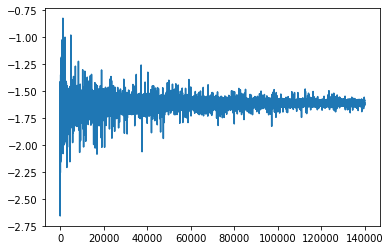

In [15]:
#print(model.all_rewards)
plt.plot(range(len(model.all_rewards)), model.all_rewards)

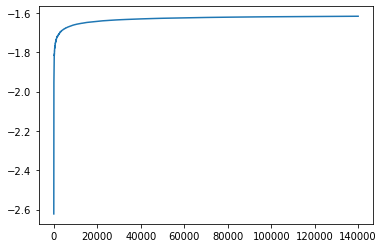

In [16]:
plt.plot(range(len(model.all_rewards)-1), [sum(model.all_rewards[:i])/i for i in range(1,len(model.all_rewards))])